# Linear piecewise function


In this notebook, we will look into how to evaluate a function using a linear piecewise approximation. This operation is based on the more general [piecewise polynomial function approximation](https://arxiv.org/abs/1805.12445). In this notebook we will have an overlook of what this requires, then we will build the operation using the elements we introduced in previous notebooks. 

## An overview

As described in the previous notebook, we look to approximate the function $f(x)$ given $x$ with a linear function within $2^m$ domains such that $f(x)\approx A_1^lx + A_0^l$ for $x$ within domain $l$.
This operation takes the form:

$$ |x\rangle^{\otimes n}_x|0\rangle^{\otimes n_a}_o \rightarrow |x\rangle^{\otimes n}_x|A_1^l x + A_0^l \rangle^{\otimes n_a}_o, $$

where we have excluded any ancillary registers. Here we will look into how this can be done. Let us break this operation down into several steps:

   1. **Initialize** registers $x$ and empty output register $o$, coefficient register $c$ and label register $l$.
   
      $$ |x\rangle^{\otimes n}_x|0\rangle^{\otimes n_a}_o|0\rangle^{\otimes n_c}_c|0\rangle^{\otimes m}_l $$
   
   2. **Label** register $l$ on register $x$ given the $2^m$ domain bounds.

      $$ |x\rangle^{\otimes n}_x|0\rangle^{\otimes n_a}_o|0\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$

   3. **Load** $A_1^l$ into register $c$ conditioned on register $l$.

      $$ |x\rangle^{\otimes n}_x|0\rangle^{\otimes n_a}_o|A_1^l\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$

   4. Perform a **multiplication** operation on registers $x$, $c$ and $o$.

      $$ |x\rangle^{\otimes n}_x|A_1^l x\rangle^{\otimes n_a}_o|A_1^l\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$

   5. **Unload** $A_1^l$ into register $c$ conditioned on register $l$.
   
      $$ |x\rangle^{\otimes n}_x|A_1^l x\rangle^{\otimes n_a}_o|0\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$
   
   6. **Load** $A_0^l$ into register $c$ conditioned on register $l$.
   
      $$ |x\rangle^{\otimes n}_x|A_1^l x\rangle^{\otimes n_a}_o|A_0^l\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$
   
   7. Perform an **addition** operation on register $c$ and $o$.
   
      $$ |x\rangle^{\otimes n}_x|A_1^l x+A_0^l\rangle^{\otimes n_a}_o|A_0^l\rangle^{\otimes n_c}_c|l\rangle^{\otimes m}_l $$
   
We can see that we need to perform a sequence of operations: label, load, multiplication and addition. These operations are depicted below, where the $X_{0,1}$ operation performs the loading of $A_0^{l}$ or $A_1^{l}$ respectively, and the inverse operation will unload the coefficient.

<img src="LPF.png">

We have already introduced loading data, multiplication and addition in previous notebooks, so first we will look into introducing the label operation.

## Label gate

Firstly, we need to form the label gate that is capable of accessing if a given value stored in the $x$ register lies within the bounds of a given domain. Essentially, this requires evaluating if $a_l \le x < a_{l+1}$ given the lower bounds of given domain $a_l$ and the boundary of the adjacent domain $a_{l+1}$. Let's look at how this can be done.

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute, Aer, IBMQ
import qiskit_tools as qt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
width=0.75
color='black'
fontsize=28
ticksize=22
figsize=(10,8)

First, lets define $x$ and the boundaries to the domains:

In [3]:
digit = 1.

bounds = np.array([-2., 0., 1.5, 3.])
print('Domain boundaries:',bounds)

Domain boundaries: [-2.   0.   1.5  3. ]


The number of qubits required to store these bounds is:

In [4]:
m = int(np.ceil(np.log2(len(bounds))))
print('Label qubits:',m)

Label qubits: 2


As usual, we determine the minimum number of qubits to store $x$ and the boundaries:

In [5]:
phase = True

nint = qt.get_nint([digit,*bounds])
npres = qt.get_npres([digit,*bounds])
n = nint + npres

if phase:
    n+=1
    
binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)

We need a quantum circuit with an $x$ register, target and ancillary registers similar to the previous notebook, and a label register to store the result:

In [6]:
qx = QuantumRegister(n, 'x')
qtarg = QuantumRegister(1, 'targ')
qans = QuantumRegister(n-1, 'a')
qlab = QuantumRegister(m, 'l')
out_reg = ClassicalRegister(m,'out')
circ = QuantumCircuit(qx, qtarg, qans, qlab, out_reg)

First we input $x$:

In [7]:
x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

Now we can apply the premade function `label_gate` that takes the domain bounds as an arguement through `bounds=bounds`.

In [8]:
circ = qt.label_gate(circ, qx, qtarg, qans, qlab, bounds=bounds, nint=nint, phase=phase)

We will measure the label register to see the result.

In [9]:
circ.measure(qlab, out_reg);

Lets have a look at the circuit:

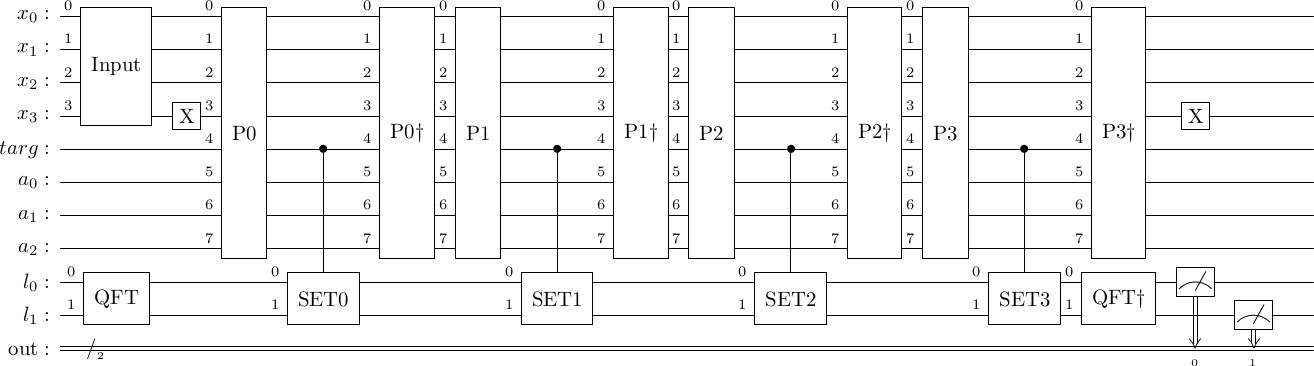

In [10]:
circ.draw('latex')

We can see that `label_gate` is composed of three operations: 'P', 'SET' and QFT. All of these operations we have encountered previously in one form or another. 

   1. The operation 'P' is the inequality condition operation from the previous notebook. There is a 'P' operation per domain boundary. Each one assesses if $a_l\le x$ and stores the boolean result in the target register.
   2. The 'SET' operation will increment the label register if the target register is in state $|1\rangle$. This means that 'SET$i$' will increment the label register when the condition $a_i\le x$ is met.
   3. The 'QFT' operation is simply the quantum Fourier transform. This is added as the increment operation of 'SET' is performed using a simple quantum Fourier transform addition. Rather than performing the quantum Fourier transform before and the inverse after every 'SET' operation, all increment operations can be performed in the conjugate basis between a single quantum Fourier transform and inverse pair.

In [11]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [12]:
print('Result:')
for label in hist.keys():
    if qt.bin_to_dec(label, nint=None, phase=False)==0.:
        print(digit,'is outwith the bounds of','['+str(bounds[0])+',',str(bounds[-1])+')','with probability',float(hist[label])/shots)
    else:
        print(bounds[int(qt.bin_to_dec(label, nint=None, phase=False))-1],'<=',digit,'<',bounds[int(qt.bin_to_dec(label, nint=None, phase=False))],'with probability',float(hist[label])/shots)

Result:
0.0 <= 1.0 < 1.5 with probability 1.0


This gives us the desired solution. Great, we have our label operation!

## Loading and unloading data

At this point, we are very familiar with the process of loading binary strings into a register with the `input_bits_to_qubits` operation. However, now we wish to load in a different value dependent on another register (in this case, the label register). We shall look into how this is done here.

First let us perform the same steps as before:

In [13]:
digit = 1.

bounds = np.array([-2., 0., 1.5, 3.])

print('Domain boundaries:',bounds)

Domain boundaries: [-2.   0.   1.5  3. ]


In [14]:
m = int(np.ceil(np.log2(len(bounds))))

phase = True

nint = qt.get_nint([digit,*bounds])
npres = qt.get_npres([digit,*bounds])
n = nint + npres

if phase:
    n+=1
    
binary_x = qt.my_binary_repr(digit, n, nint=nint, phase=phase)
print('Label qubits:',m)

Label qubits: 2


Additionally, we need to determine the number of integer and precision bits requires to store the coefficients $A_1^l$. For simplicity, we shall make the bit strings for $x$ and $A_1^l$ of equal length:

In [15]:
A1s = np.array([3., -1., 2.5, -0.5])

nintc = qt.get_nint(A1s)
npresc = qt.get_npres(A1s)
nc = nintc + npresc

if phase:
    nc+=1
    
n = np.max([n,nc])

We will need an $n$ qubit coefficient register to load the values of $A_1^l$, as well as the $x$ and label registers:

In [16]:
qx = QuantumRegister(n, 'x')
qcoff = QuantumRegister(n, 'c')
qlab = QuantumRegister(m, 'l')
out_reg = ClassicalRegister(n,'out')
circ = QuantumCircuit(qx, qcoff, qlab, out_reg)

As we first need to label $x$, we need $n$ ancillary qubits to apply `label_gate`. However these qubits can be from the coefficient register as they are initially unused:

In [17]:
qtarg = qcoff[0] 
qans = qcoff[1:]

Let us input $x$ and apply the `label_gate` again:

In [18]:
x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

l_gate = qt.label_gate(circ, qx, qtarg, qans, qlab, bounds=bounds, nint=nint, phase=phase, wrap=True)
circ.append(l_gate, [*qx, qtarg, *qans, *qlab]);

We can input the domain dependent coefficients using the `cin_gate` taking the coefficients as an input, as well as the number of integer qubits:

In [19]:
circ = qt.cin_gate(circ, qcoff, qlab, A1s, nint=nintc, phase=phase)

Let us then measure the coefficient register and see what value it produces, given the input $x$ and the domain bounds.

In [20]:
circ.measure(qcoff, out_reg);

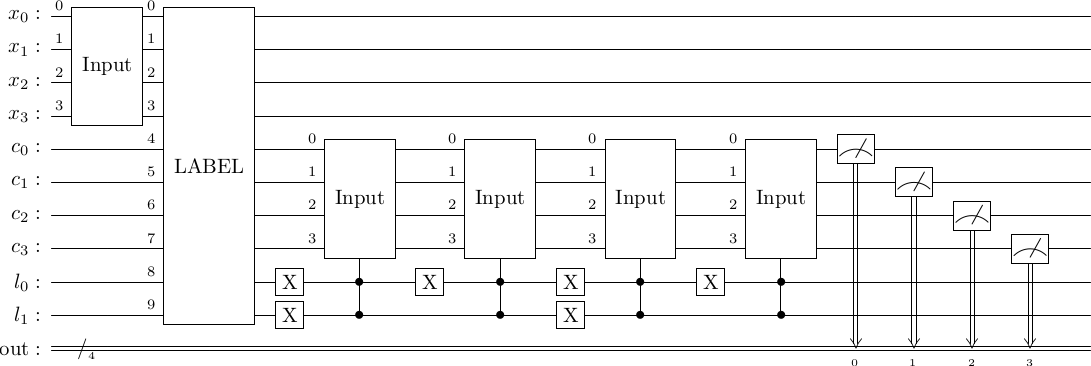

In [21]:
circ.draw('latex')

The above circuit displays the components of the `cin_gate` operation. It consists of an `input_bits_to_qubits` operation per domain, controlled on the label register, where $X$ gates permute through all configurations of the label register states.

Let us simulate some measurements and see what value the coefficient register returns:

In [22]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [23]:
print('Target:')
ind = np.argwhere((np.array([bounds[-1],*bounds[:-1]])<=digit)*(bounds>digit)).flatten()[0]
print(A1s[ind],'as',bounds[ind-1],'<=',digit,'<',bounds[ind])

print('Result:')
for label in hist.keys():
    print(qt.bin_to_dec(label, nint=nintc, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Target:
2.5 as 0.0 <= 1.0 < 1.5
Result:
2.5 -> 0101 with probability 1.0


We recover the desired coefficient!

Unloading is simply the inverse of this operation. Let us have a look at an example of loading and the unloading the coefficients:

In [24]:
qx = QuantumRegister(n, 'x')
qcoff = QuantumRegister(n, 'c')
qlab = QuantumRegister(m, 'l')
out_reg = ClassicalRegister(n,'out')
circ = QuantumCircuit(qx, qcoff, qlab, out_reg)

qtarg = qcoff[0] 
qans = qcoff[1:]

x_gate = qt.input_bits_to_qubits(binary_x, circ, reg=qx, wrap=True)
circ.append(x_gate, qx);

l_gate = qt.label_gate(circ, qx, qtarg, qans, qlab, bounds=bounds, nint=nint, phase=phase, wrap=True)
circ.append(l_gate, [*qx, qtarg, *qans, *qlab]);

X_gate = qt.cin_gate(circ, qcoff, qlab, A1s, nint=nintc, phase=phase, wrap=True, label='X')
X_gate_inv = qt.cin_gate(circ, qcoff, qlab, A1s, nint=nintc, phase=phase, wrap=True, inverse=True, label='X')
circ.append(X_gate, [*qcoff, *qlab]);
circ.append(X_gate_inv, [*qcoff, *qlab]);

circ.measure(qcoff, out_reg);

This looks like this:

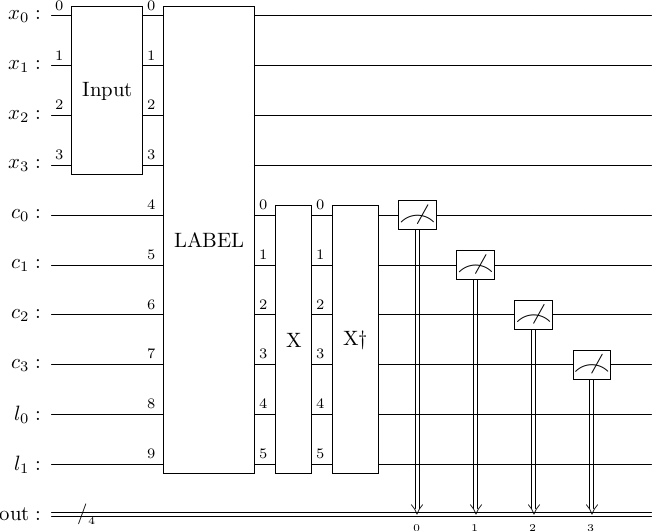

In [25]:
circ.draw('latex')

In [26]:
shots=10
emulator = Aer.get_backend('qasm_simulator')
job = execute(circ, emulator, shots=shots )
hist = job.result().get_counts()

In [27]:
print('Result:')
for label in hist.keys():
    print(qt.bin_to_dec(label, nint=nintc, phase=phase),'->',label,'with probability',float(hist[label])/shots)

Result:
0.0 -> 0000 with probability 1.0


As desired!

## Putting it all together

With our knowledge on addition and multiplication, and now that we know how to label, load and unload the coefficients, we have all we need to perform the linear piecewise approximation!

Similar to the previous notebook, let us begin by defining the function we wish to model:

In [28]:
def f_x(x):
    return np.arctan(x)

And the range of variables we wish to apply the function over by setting the scale and precison of the $x$ register:

In [29]:
phase = True

nintx = 3
nx = 5
npresx = nx - nintx
if phase:
    npresx-=1

xmin = -2.**(nintx)
xmax = 2.**(nintx) - 2.**(-npresx)

xs = np.linspace(xmin,xmax,2**nx)

We set the desired number of precision bits of the input coefficients:

In [30]:
npres0, npres1 = 4, 4

and both the polynomial degree we wish to approximate to inside the given domains (currently only linear approximations are encoded), as well as the number of bits used to define the number of domains $m$:

In [31]:
norder = 1
m = 3

We return the total number of bits and integer bits for the output and coefficient register, as well as the uniform bounds and corresponding coefficients given the desired precision:

In [32]:
n, n0, nint, nintcs, coeffs, bounds = qt.optimize_coeffs_qubits(f_x, xs, m, npres0, npres1, norder=norder, phase=phase, label_swap=True)

In [33]:
print('Qubits:', nx, n, n0, m)
print('Integer qubits:', nintx, nint, nintcs[0,0], nintcs[0,1])
print('Memory:', 16*(2**(n+n0+nx+m))/2**20)

Qubits: 5 7 6 3
Integer qubits: 3 1 1 1
Memory: 32.0


Let us save the coefficients as another variable but with `label_swap=False` so that they are ordered in an intuative way, and give them to `piecewise_poly`:

In [34]:
_, _, _, _, coeffs_, _ = qt.optimize_coeffs_qubits(f_x, xs, m, npres0, npres1, norder=norder, phase=phase, label_swap=False)
ys_rnd = qt.piecewise_poly(xs, coeffs_.T, bounds)

We now need to initialize our $x$, output, label and coefficient register into a quantum circuit:

In [35]:
qx = QuantumRegister(nx, 'x')
qout = QuantumRegister(n, 'o')
qlab = QuantumRegister(m, 'l')
qcoff = QuantumRegister(n0, 'c')
circ = QuantumCircuit(qx, qout, qlab, qcoff)

Now we can perform the steps we formed from the start:

In [36]:
# 1. Initialize the x register (let as produce a superposition across all x values)
for i in np.arange(nx):
    circ.h(qx[i]);

# We can use the coefficient register as the ancillary register for the labelling step as before
qtarg = qcoff[0] 
qans = [*qcoff[1:], *qout][:nx-1]

# 2. Label the data with the labelling operation
l_gate = qt.label_gate(circ, qx, qtarg, qans, qlab, bounds=bounds, nint=nintx, phase=phase, wrap=True)
circ.append(l_gate, [*qx, qtarg, *qans, *qlab]);

# 3. Load A1 into the coefficient register conditioned on the label register
X1_gate = qt.cin_gate(circ, qcoff, qlab, coeffs[0], nint=nintcs[0,0], phase=phase, wrap=True)
circ.append(X1_gate, [*qcoff, *qlab]);

# 4. Multiply the coefficient and x registers and save the output on the output register
mul_gate = qt.QFTMultPhase(circ, qcoff, qx, qout, wrap=True, nint1=nintcs[0,0], nint2=nintx, nint3=nint)
circ.append(mul_gate, [*qcoff, *qx, *qout]);

# 5. Unload A1 from the coefficient register with the inverse load operation
X1_gate_inv = qt.cin_gate(circ, qcoff, qlab, coeffs[0], nint=nintcs[0,0], phase=phase, wrap=True, inverse=True)
circ.append(X1_gate_inv, [*qcoff, *qlab]);

# 6. Load A0 into the coefficient register conditioned on the label register
X0_gate = qt.cin_gate(circ, qcoff, qlab, coeffs[1], nint=nintcs[0,1], phase=phase, wrap=True)
circ.append(X0_gate, [*qcoff, *qlab]);

# 7. Add the coefficient register to the output register
add_gate = qt.QFTAddition(circ, qcoff, qout, nint1=nintcs[0,1], nint2=nint, wrap=True, phase=phase)
circ.append(add_gate, [*qcoff, *qout]);

# Unload A0 to clear the coefficient register
X0_gate_inv = qt.cin_gate(circ, qcoff, qlab, coeffs[1], nint=nintcs[0,1], phase=phase, wrap=True, inverse=True)
circ.append(X0_gate_inv, [*qcoff, *qlab]);

# Unlabel the label register
l_gate_inv = qt.label_gate(circ, qx, qtarg, qans, qlab, bounds=bounds, nint=nintx, phase=phase, wrap=True, inverse=True)
circ.append(l_gate_inv, [*qx, qtarg, *qans, *qlab]);

Now we can retreive the state vector using the simulator:

In [37]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = result.get_statevector()

To unravel the state vector we reshape it and summate across the empty registers:

In [38]:
state_v = np.asarray(state_vector).reshape((2**n0,2**m,2**n,2**nx)).T
state_v = np.sum(state_v, axis=(2,3))

Now let us take the positions of non-zero amplitudes across the output register dimension of the state vector, and convert the integer positions to the corresponding values of $f(x)$:

In [39]:
y_unorm = np.argwhere(np.round(np.abs(state_v)**2,15)>0.)[:,1]
y_out = []
for y in y_unorm:
    y_out.append(qt.bin_to_dec(qt.my_binary_repr(y, n=n, nint=None, phase=False), nint=nint, phase=phase))

The output must be reordered as the $x$ register is in the twos-complement representation:

In [40]:
xs_comp = []
xs_ = np.linspace(-2**(nx-1),2**(nx-1)-1,2**nx)
for x in xs_:
    binary = qt.my_binary_repr(x, nx, nint=None, phase=True)
    xs_comp.append(int(qt.bin_to_dec(binary, nint=None, phase=False)))

y_out = np.array(y_out)[xs_comp]

Let us see these values and how they compare to the desired function:

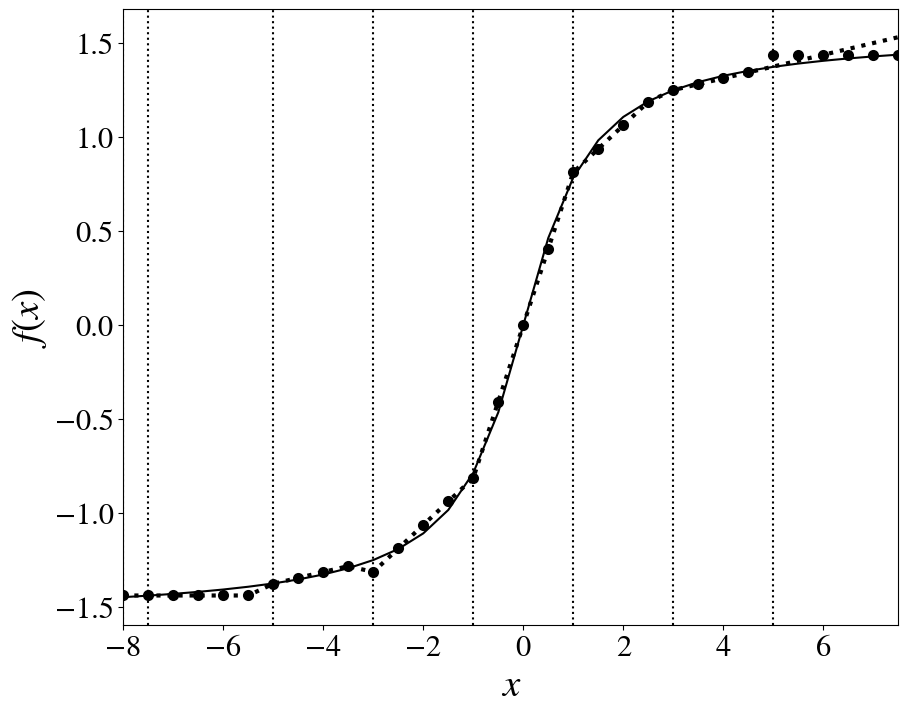

In [41]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

for bound in bounds:
    ax.axvline(bound, ls=':', color='black')
    
ax.plot(xs, f_x(xs), color='black');
ax.scatter(xs, y_out, color='black', lw=2);
ax.plot(xs, ys_rnd, color='black', ls=':', lw=3);
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$f(x)$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);
plt.show()

Fantastic! Our state vector is now an approximation of $f(x)$ as desired.

In [42]:
def f_x(x):
    return np.arctan(x)

In [43]:
phase = True
phasex = True

nintx = 3
nx = 5
npresx = nx - nintx

xmin = 0.

if phasex:
    npresx-=1
    xmin = -2.**(nintx)
    
xmax = 2.**(nintx) - 2.**(-npresx)


xs = np.linspace(xmin,xmax,2**nx)

In [44]:
n, n0, nint, nintcs, coeffs, bounds = qt.optimize_coeffs_qubits(f_x, xs, m, npres0, npres1, norder=norder, phase=phase, label_swap=True)

In [45]:
print('Qubits:', nx, n, n0, m)
print('Integer qubits:', nintx, nint, nintcs[0,0], nintcs[0,1])
print('Memory:', 16*(2**(n+n0+nx+m))/2**20)

Qubits: 5 7 6 3
Integer qubits: 3 1 1 1
Memory: 32.0


In [46]:
qx = QuantumRegister(nx, 'x')
qout = QuantumRegister(n, 'o')
qlab = QuantumRegister(m, 'l')
qcoff = QuantumRegister(n0, 'c')
circ = QuantumCircuit(qx, qout, qlab, qcoff)

In [47]:
for i in np.arange(nx):
    circ.h(qx[i]);

lpf_gate = qt.lpf(circ, qx, qout, qlab, qcoff, coeffs, bounds, nintx=nintx, nintcs=nintcs, nint=nint, phase=phase, phasex=phasex, wrap=True)
circ.append(lpf_gate, [*qx, *qout, *qlab, *qcoff]);

In [48]:
backend = Aer.get_backend('statevector_simulator')
job = execute(circ, backend)
result = job.result()
state_vector = result.get_statevector()

In [49]:
state_v = np.asarray(state_vector).reshape((2**n0,2**m,2**n,2**nx)).T
state_v = np.sum(state_v, axis=(2,3))

In [50]:
y_unorm = np.argwhere(np.round(np.abs(state_v)**2,15)>0.)[:,1]
y_out = []
for y in y_unorm:
    y_out.append(qt.bin_to_dec(qt.my_binary_repr(y, n=n, nint=None, phase=False), nint=nint, phase=phase))

In [51]:
xs_comp = []
xs_ = np.linspace(-2**(nx-1),2**(nx-1)-1,2**nx)
for x in xs_:
    binary = qt.my_binary_repr(x, nx, nint=None, phase=True)
    xs_comp.append(int(qt.bin_to_dec(binary, nint=None, phase=False)))

y_out = np.array(y_out)[xs_comp]

In [52]:
Ax = qt.piecewise_poly(xs, np.array([coeffs_[0],np.zeros(len(coeffs_[1]))]).T, bounds)

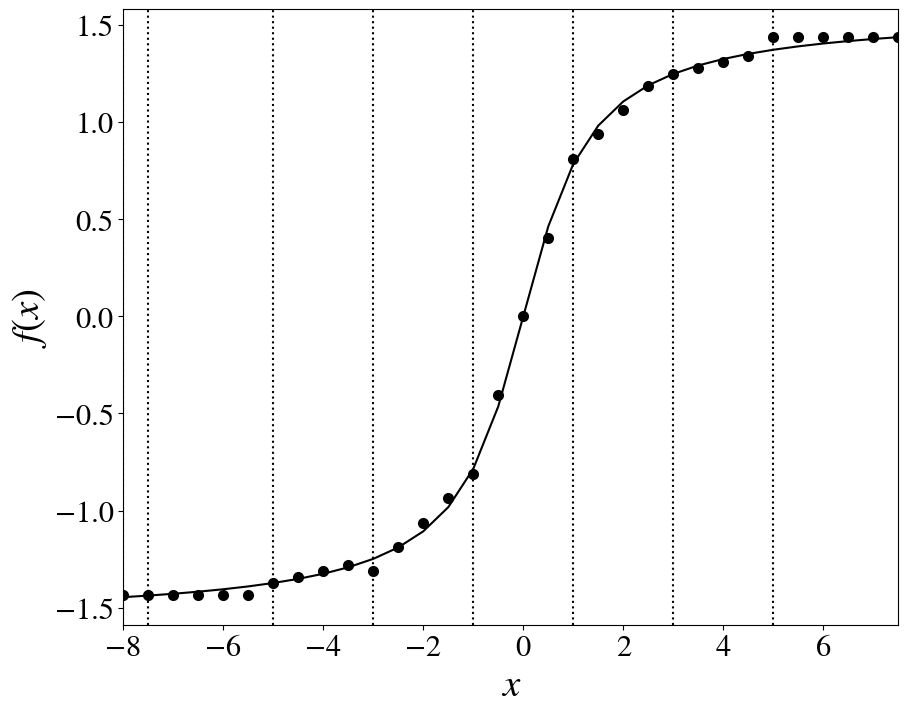

In [53]:
fig = plt.figure(figsize=figsize)
ax = fig.gca()

for bound in bounds:
    ax.axvline(bound, ls=':', color='black')
    
ax.plot(xs, f_x(xs), color='black');
ax.scatter(xs, y_out, color='black', lw=2);
#ax.plot(xs, Ax, color='black', lw=2);
ax.set_xlabel(r'$x$', fontsize=fontsize);
ax.set_ylabel(r'$f(x)$', fontsize=fontsize);
ax.set_xlim(xmin,xmax);
ax.tick_params(axis='both', labelsize=ticksize);
plt.show()